In [173]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import skimage
from dnn_app_utils_v2 import *
from dnn_utils_v2 import *
from testCases_v4 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)



In [175]:
# Cargar los datos
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 1. It's a cat picture.


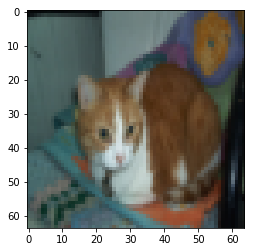

In [147]:
# Ejemplo de Figura
index = 134
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [176]:
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [149]:

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [151]:
# inicializar parametros

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.random.randn(n_h, 1)*0.01
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.random.randn(n_y, 1)*0.01
    
    assert(W1.shape == (n_h, n_x))
    assert(b1.shape == (n_h, 1))
    assert(W2.shape == (n_y, n_h))
    assert(b2.shape == (n_y, 1))
    parameters = {"W1": W1,
    "b1": b1,
    "W2": W2,
    "b2": b2}
    
    return parameters

In [152]:
# FUNCCION: initialize_parameters_deep
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1)) 
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [153]:
# FUNCTION: linear_forward
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [154]:
# FUNCTION: linear_activation_forward
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

In [155]:
# FUNCTION: L_model_forward
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    caches = list()
    # número de capas de la red
    # Implemente [LINEAR -> RELU]*(L-1). Agregue "cache" a la lista "caches"
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, 
                                             parameters["W" + str(l)], 
                                             parameters["b" + str(l)], 
                                             activation='relu')
        caches.append(cache)
    
    # Implementa LINEAR -> SIGMOID. Agregue "cache" a la lista "caches".
    
    AL, cache = linear_activation_forward(A, 
                                             parameters["W" + str(L)], 
                                             parameters["b" + str(L)], 
                                             activation='sigmoid')
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
    return AL, caches

In [156]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = -(1/m)*np.sum(Y*np.log(AL)+ (1-Y)*np.log(1- AL))
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    return cost

In [157]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m)*np.dot(dZ, cache[0].T) 
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(cache[1].T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

In [158]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db

In [159]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    # Iniciando el backpropagation
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # en cada capa l (SIGMOID -> LINEAR) gradients. Entrada: "dAL, current_cache". Salida: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    
    
    # Loop de l=L-2 to l=0
    for l in reversed(range(L-1)):
    # En cada capa l: (RELU -> LINEAR) gradients.
    # Entrada: "grads["dA" + str(l + 1)], current_cache". Salida: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)]
    
        current_cache = caches[l]    
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation="relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [163]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # numero de capas de la red
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    return parameters

In [177]:
### CONSTANTS ###
layers_dims = [train_x.shape[0], 20, 7, 5, 1] #  5-layer model

In [188]:
# GRADED FUNCTION: L_layer_model

def mimodelo(X, Y, layers_dims, learning_rate = 0.02, num_iterations = 2000, print_cost=False):
    

    np.random.seed(1)
    costs = []
    
    parameters = initialize_parameters_deep(layers_dims)
  
    for i in range(0, num_iterations):

  
        AL, caches = L_model_forward(X, parameters)
 
        cost = compute_cost(AL, Y)
     
        grads = L_model_backward(AL, Y, caches)

        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        
        #costo
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
parameters = mimodelo(train_x, train_y, layers_dims, num_iterations = 2000, print_cost = True)

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.659669
Cost after iteration 200: 0.648594
Cost after iteration 300: 0.644263
Cost after iteration 400: 0.641504
Cost after iteration 500: 0.625011
Cost after iteration 600: 0.547660
Cost after iteration 700: 0.422634
Cost after iteration 800: 0.526179
Cost after iteration 900: 0.275194
Cost after iteration 1000: 0.240979
Cost after iteration 1100: 0.138454


In [ ]:
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)